# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project

---

#### [Capstone Project, Part 1: Proposal](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part1-proposal.ipynb)
#### [Capstone Project, Part 2: Brief](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb)
- [Writing data to MongoDB](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#mongo_db)
- [Data Dictionary](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#data_dictionary)
- [Map of races around the world](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#world-map)

#### [Capstone Project, Part 3: Technical Notebook](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb)
- [Feature Engineering](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_eng)
- [Regression Approaches](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#regression_approaches)
- [Classification Approaches](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#classification_approaches)
- [Feature Importance](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_importance)
- [Feature Selection](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_selection)
- [Models Comparison](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#models_comparison)

#### [Capstone Project, Part 4: Presentation](https://61c08c5e1627a3416b0c37b4--pensive-nobel-d54f9f.netlify.app/)
#### [Capstone Project, Part 5: Appendix](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part5-appendix.ipynb)

#### [Capstone Project, Part 6: MLOps](https://github.com/jaeyow/f1-predictor/blob/main/.github/workflows/f1-mlops.yml)
Using GitHub Actions as a cheap (and free) MLOps tool alternative: - invoke MLOps workflow on-demand (or with a cron schedule)
- get latest source
- setup Python build/MLOps environment
- data retrieval and preparation
- feature engineering
- preparation for model training (including dummify categorical features)
- feature selection
- model building and scoring
- setup serverless (lambda) API in AWS
- deploy model to serverless API
- profit!

![](./images/f1-mclaren-car.png)

In [5]:
# install modules first
!pip install pandas
!pip install matplotlib

     |████████████████████████████████| 7.3 MB 640 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 309 kB/s eta 0:00:01
     |████████████████████████████████| 61 kB 560 kB/s eta 0:00:01
     |████████████████████████████████| 890 kB 593 kB/s eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date
from datetime import datetime
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, explained_variance_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ARDRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')


In [135]:
results_df = pd.read_csv('results_from_mongo.csv')
results_df.drop(columns=['Unnamed: 0'],inplace=True)


In [136]:
# only keep 2021 for the api
api_df = results_df[results_df['Season']==2021]
api_df.reset_index(drop=True, inplace=True)
api_df.to_csv(f'2021_races_drivers.csv')

<a id='feature_eng'></a>
### Feature Engineering

At this stage, we will be creating the following features from exiting data:
- Driver experience
- Constructor experience
- Driver Recent Wins
- Driver Age
- Driver Recent Form
- Driver recent DNFs
- Home Circuit advantage
- Dummify the following categorical parameters: Season?, Race Name?, Number of Laps, Weather


#### Driver experience
Driver's experience in Formula 1, where a more experienced F1 driver typically places better than a rookie.

In [137]:
results_df['DriverExperience'] = 0
drivers = results_df['Driver'].unique()
for driver in drivers:
    df_driver = pd.DataFrame(results_df[results_df['Driver']==driver]).tail(60) # Arbitrary number, just look at the last x races
    df_driver.loc[:,'DriverExperience'] = 1
    
    results_df.loc[results_df['Driver']==driver, "DriverExperience"] = df_driver['DriverExperience'].cumsum()
    results_df['DriverExperience'].fillna(value=0,inplace=True)


#### Constructor Experience
Constructor's experience in Formula 1, where a more experienced F1 constructor typically places better than a rookie.

In [138]:
results_df['ConstructorExperience'] = 0
constructors = results_df['Constructor'].unique()
for constructor in constructors:
    
    df_constructor = pd.DataFrame(results_df[results_df['Constructor']==constructor]).tail(60) # Arbitrary number, just look at the last x races per driver
    df_constructor.loc[:,'ConstructorExperience'] = 1
    
    results_df.loc[results_df['Constructor']==constructor, "ConstructorExperience"] = df_constructor['ConstructorExperience'].cumsum()
    results_df['ConstructorExperience'].fillna(value=0,inplace=True)


#### Driver Recent Wins
A new feature is added to represent the dirver's most recent past wins. Excluding the result of the current race ensures that there is no possibility of data leakage that might affect the results. 

In [139]:
results_df['DriverRecentWins'] = 0
drivers = results_df['Driver'].unique()

results_df.loc[results_df['Position']==1, "DriverRecentWins"] = 1
for driver in drivers:
    mask_first_place_drivers = (results_df['Driver']==driver) & (results_df['Position']==1)
    df_driver = results_df[mask_first_place_drivers]
    results_df.loc[results_df['Driver']==driver, "DriverRecentWins"] = results_df[results_df['Driver']==driver]['DriverRecentWins'].rolling(60).sum() # 60 races, about 3 years rolling
    results_df.loc[mask_first_place_drivers, "DriverRecentWins"] = results_df[mask_first_place_drivers]['DriverRecentWins'] - 1  # but don't count this race's win
    results_df['DriverRecentWins'].fillna(value=0,inplace=True)


#### Driver Recent DNFs

A new feature has also been added to represent a driver's recent DNFs (Did Not Finish), whatever/whoever's fault it is. We also have to take care and avoid data leakage into this new feature, by not counting the current race. 

In [140]:
results_df['DriverRecentDNFs'] = 0
drivers = results_df['Driver'].unique()

results_df.loc[(~results_df['Status'].str.contains('Finished|\+')), "DriverRecentDNFs"] = 1
for driver in drivers:
    mask_not_finish_place_drivers = (results_df['Driver']==driver) & (~results_df['Status'].str.contains('Finished|\+'))
    df_driver = results_df[mask_not_finish_place_drivers]
    results_df.loc[results_df['Driver']==driver, "DriverRecentDNFs"] = results_df[results_df['Driver']==driver]['DriverRecentDNFs'].rolling(60).sum() # 60 races, about 3 years rolling
    results_df.loc[mask_not_finish_place_drivers, "DriverRecentDNFs"] = results_df[mask_not_finish_place_drivers]['DriverRecentDNFs'] - 1  # but don't count this race
    results_df['DriverRecentDNFs'].fillna(value=0,inplace=True)

# results_df[results_df['Driver']=='Daniel Ricciardo'].tail(60)

#### Fix issues with Recent form values

In Formula 1, only the top 10 finishers score points, so even if a driver finished 11th, they will not score anything which will not help our calculation. So in this part, we give all finishers a score. The 1st place top points, and lower places get lower points and so on. We can then use this column as a variable (instead of F1's official points) to calclulate for the the Driver's recent form. 

In [141]:
# Add new RFPoints column - ALL finishers score points - max points First place and one less for each lesser place (using LogSpace)
seasons = results_df['Season'].unique()
results_df['RFPoints'] = 0
for season in seasons:
    rounds = results_df[results_df['Season']==season]['Round'].unique()
    for round in rounds:
        mask = (results_df['Season']==season) & (results_df['Round']==round)
        finisher_mask = ((results_df['Status'].str.contains('Finished|\+'))) # Count only if finished the race
        finished_count = results_df.loc[(mask) & finisher_mask, "RFPoints"].count()
        point_list = np.round(np.logspace(1,4,40, base=4),4) # use list of LogSpaced numbers
        point_list[::-1].sort()
        
        results_df.loc[(mask) & finisher_mask, "RFPoints"] = point_list[:finished_count].tolist()


#### Driver Recent Form
Now that we've got our adjusted points system "RFPoints", we can now calculate for a more accurate Driver Recent Form. We also have to take care and avoid data leakage into this new feature.

In [142]:
results_df['DriverRecentForm'] = 0
# for all drivers, calculate the rolling X DriverRecentForm and add to a new column in 
# original data frame, this represents the 'recent form', then for NA's just impute to zero
drivers = results_df['Driver'].unique()
for driver in drivers:
    df_driver = results_df[results_df['Driver']==driver]
    results_df.loc[results_df['Driver']==driver, "DriverRecentForm"] = df_driver['RFPoints'].rolling(30).sum() - df_driver['RFPoints'] # calcluate recent form points but don't include this race's points
    results_df['DriverRecentForm'].fillna(value=0,inplace=True)


#### Constructor Recent Form
Now that we've got our adjusted points system "RFPoints", we can now also calculate for a more accurate Constructor Recent Form. We also have to take care and avoid data leakage into this new feature.

In [143]:
results_df['ConstructorRecentForm'] = 0
# for all constructors, calculate the rolling X RFPoints and add to a new column in 
# original data frame, this represents the 'recent form', then for NA's just impute to zero
constructors = results_df['Constructor'].unique()
for constructor in constructors:
    df_constructor = results_df[results_df['Constructor']==constructor]
    results_df.loc[results_df['Constructor']==constructor, "ConstructorRecentForm"] = df_constructor['RFPoints'].rolling(30).sum() - df_constructor['RFPoints'] # calcluate recent form points but don't include this race's points
    results_df['ConstructorRecentForm'].fillna(value=0,inplace=True)


#### Driver Age
Surely a driver's age has some effect and may have some influence to the outcome of the race. 

In [144]:
def calculate_age(born, race):
    date_born = datetime.strptime(born,'%Y-%m-%d')
    date_race = datetime.strptime(race,'%Y-%m-%d')
    return date_race.year - date_born.year - ((date_race.month, date_race.day) < (date_born.month, date_born.day))

results_df['Age'] = results_df.apply(lambda x: calculate_age(x['DOB'], x['Race Date']), axis=1) 


#### Home Circuit
Is there such a thing as Homecourt Advantage in Formula 1 racing? It doesn't look like it does, based on the preliminary EDA, however, I've got a feeling that it might have some. In the following cell, I have created a mapping between driver nationality vs race country, and this is used when we want to convey the Homecourt advantage concept in this model. 

In [145]:
def is_race_in_home_country(driver_nationality, race_country):
    nationality_country_map = {
        'American': ['USA'],
        'American-Italian': ['USA','Italy'],
        'Argentine': ['Argentina'],
        'Argentine-Italian': ['Argentina','Italy'],
        'Australian': ['Australia'],
        'Austrian': ['Austria'],
        'Belgian': ['Belgium'],
        'Brazilian': ['Brazil'],
        'British': ['UK'],
        'Canadian': ['Canada'],
        'Chilean': ['Brazil'],
        'Colombian': ['Brazil'],
        'Czech': ['Austria','Germany'],
        'Danish': ['Germany'],
        'Dutch': ['Netherlands'],
        'East German': ['Germany'],
        'Finnish': ['Germany','Austria'],
        'French': ['France'],
        'German': ['Germany'],
        'Hungarian': ['Hungary'],
        'Indian': ['India'],
        'Indonesian': ['Singapore','Malaysia'],
        'Irish': ['UK'],
        'Italian': ['Italy'],
        'Japanese': ['Japan','Korea'],
        'Liechtensteiner': ['Switzerland','Austria'],
        'Malaysian': ['Malaysia','Singapore'],
        'Mexican': ['Mexico'],
        'Monegasque': ['Monaco'],
        'New Zealander': ['Australia'],
        'Polish': ['Germany'],
        'Portuguese': ['Portugal'],
        'Rhodesian': ['South Africa'],
        'Russian': ['Russia'],
        'South African': ['South Africa'],
        'Spanish': ['Spain','Morocco'],
        'Swedish': ['Sweden'],
        'Swiss': ['Switzerland'],
        'Thai': ['Malaysia'],
        'Uruguayan': ['Argentina'],
        'Venezuelan': ['Brazil']
    }
    
    countries = ['None']
    
    try:
      countries = nationality_country_map[driver_nationality]
    except:
      print("An exception occurred, This driver has no race held in his home country.")
    return race_country in countries

results_df['IsHomeCountry'] = results_df.apply(lambda x: is_race_in_home_country(x['Nationality'], x['Country']), axis=1) 


#### Handle all categorical variables
Dummify applicable categorical variables and ensure that the variables for the model are all numeric.
- Weather
- Race name (circuit)
- Driver nationality


#### Dummify FTW
Dummify the following parameters, and just drop irrelevant columns

In [ ]:
# Weather
results_df = pd.get_dummies(results_df, columns = ['Weather', 'Nationality', 'Race Name'],drop_first=True)

for col in results_df.columns:
    if 'Nationality' in col and results_df[col].sum() < 300:
        results_df.drop(col, axis = 1, inplace = True)
        
    elif 'Race Name' in col and results_df[col].sum() < 130:
        results_df.drop(col, axis = 1, inplace = True)
        
    else:
        pass
results_df.columns.tolist()

['Season',
 'Round',
 'Race Date',
 'Race Time',
 'Position',
 'Points',
 'Grid',
 'Laps',
 'Status',
 'Driver',
 'DOB',
 'Constructor',
 'Constructor Nat',
 'Circuit Name',
 'Race Url',
 'Lat',
 'Long',
 'Locality',
 'Country',
 'DriverExperience',
 'ConstructorExperience',
 'DriverRecentWins',
 'DriverRecentDNFs',
 'RFPoints',
 'DriverRecentForm',
 'ConstructorRecentForm',
 'Age',
 'IsHomeCountry',
 'Weather_weather_cold',
 'Weather_weather_dry',
 'Weather_weather_hot',
 'Weather_weather_warm',
 'Weather_weather_wet',
 'Nationality_Argentine',
 'Nationality_Australian',
 'Nationality_Austrian',
 'Nationality_Belgian',
 'Nationality_Brazilian',
 'Nationality_British',
 'Nationality_Canadian',
 'Nationality_Dutch',
 'Nationality_Finnish',
 'Nationality_French',
 'Nationality_German',
 'Nationality_Italian',
 'Nationality_Japanese',
 'Nationality_Mexican',
 'Nationality_New Zealander',
 'Nationality_Spanish',
 'Nationality_Swedish',
 'Nationality_Swiss',
 'Race Name_Abu Dhabi Grand Prix

In [108]:
#### Drop Columns which are not needed/required for modelling
results_df.drop(['Race Date', 'Race Time', 'Status', 'DOB', 'Constructor', 'Constructor Nat', 'Circuit Name',
                 'Race Url', 'Lat', 'Long', 'Locality', 'Country','Laps','Points',
                 'RFPoints'], axis=1, inplace=True)
results_df.shape


(25380, 68)

In [110]:
results_df['Season'] = pd.to_numeric(results_df['Season'])
results_df.columns

Index(['Season', 'Round', 'Position', 'Grid', 'Driver', 'DriverExperience',
       'ConstructorExperience', 'DriverRecentWins', 'DriverRecentDNFs',
       'DriverRecentForm', 'ConstructorRecentForm', 'Age', 'IsHomeCountry',
       'Weather_weather_cold', 'Weather_weather_dry', 'Weather_weather_hot',
       'Weather_weather_warm', 'Weather_weather_wet', 'Nationality_Argentine',
       'Nationality_Australian', 'Nationality_Austrian', 'Nationality_Belgian',
       'Nationality_Brazilian', 'Nationality_British', 'Nationality_Canadian',
       'Nationality_Dutch', 'Nationality_Finnish', 'Nationality_French',
       'Nationality_German', 'Nationality_Italian', 'Nationality_Japanese',
       'Nationality_Mexican', 'Nationality_New Zealander',
       'Nationality_Spanish', 'Nationality_Swedish', 'Nationality_Swiss',
       'Race Name_Abu Dhabi Grand Prix', 'Race Name_Argentine Grand Prix',
       'Race Name_Australian Grand Prix', 'Race Name_Austrian Grand Prix',
       'Race Name_Bahrain Gra

In [81]:
scoring_raw ={'model':[], 'params': [], 'score': [], 'train_time': [], 'test_time': []}

In [82]:
from sklearn.preprocessing import MinMaxScaler
# Prepare train set
np.set_printoptions(precision=4)
model_df = results_df.copy()
model_df['Position'] = model_df['Position'].map(lambda x: 1 if x == 1 else 0)

train = model_df[(model_df['Season'] >= 1950) & (model_df['Season'] < 2021)]
X_train = train.drop(['Position','Driver'], axis = 1)
y_train = train['Position']

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train, y_train), columns = X_train.columns)


In [83]:
model_df.columns

Index(['Season', 'Round', 'Position', 'Grid', 'Driver', 'DriverExperience',
       'ConstructorExperience', 'DriverRecentWins', 'DriverRecentDNFs',
       'DriverRecentForm', 'ConstructorRecentForm', 'Age', 'IsHomeCountry',
       'Weather_weather_cold', 'Weather_weather_dry', 'Weather_weather_hot',
       'Weather_weather_warm', 'Weather_weather_wet', 'Nationality_Argentine',
       'Nationality_Australian', 'Nationality_Austrian', 'Nationality_Belgian',
       'Nationality_Brazilian', 'Nationality_British', 'Nationality_Canadian',
       'Nationality_Dutch', 'Nationality_Finnish', 'Nationality_French',
       'Nationality_German', 'Nationality_Italian', 'Nationality_Japanese',
       'Nationality_Mexican', 'Nationality_New Zealander',
       'Nationality_Spanish', 'Nationality_Swedish', 'Nationality_Swiss',
       'Race Name_Abu Dhabi Grand Prix', 'Race Name_Argentine Grand Prix',
       'Race Name_Australian Grand Prix', 'Race Name_Austrian Grand Prix',
       'Race Name_Bahrain Gra


#### Regression Function

In [84]:
def regression_test_score(model, print_output=False):
    # --- Test ---
    score = 0
    races = model_df[(model_df['Season'] == 2021)]['Round'].unique()
    for race in races:
        test = model_df[(model_df['Season'] == 2021) & (model_df['Round'] == race)]
        X_test = test.drop(['Position','Driver'], axis = 1)
        y_test = test['Position']
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        X_test.to_csv(f'{2021}_{race}.csv')

        # make predictions
        prediction_df = pd.DataFrame(model.predict(X_test), columns = ['prediction'])
        merged_df = pd.concat([prediction_df, test[['Driver','Position']].reset_index(drop=True)], axis=1)
        merged_df.rename(columns = {'Position': 'actual_pos'}, inplace = True)
        
        # shuffle data to remove original order that will influence selection
        # of race winner when there are drivers with identical win probablilities
        merged_df = merged_df.sample(frac=1).reset_index(drop=True) 
        merged_df.sort_values(by='prediction', ascending=False, inplace=True)
        merged_df['predicted_pos'] = merged_df['prediction'].map(lambda x: 0)
        merged_df.iloc[0, merged_df.columns.get_loc('predicted_pos')] = 1
        merged_df.reset_index(drop=True, inplace=True)
        if (print_output == True):
            print(merged_df)

        # --- Score --- 
        score += precision_score(merged_df['actual_pos'], merged_df['predicted_pos'], zero_division=0)
        
    return score / len(races)


#### Dumb Classifier

I have created a a dumb classifier and all it does is create a list of numbers between 0.001 and 0.99 which represents the order of finishing, and shuffle for good measure

In [22]:
class F1OracleDumbClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # numbers between 0.001 to 0.99 and shuffle - jose's awesome dumb classifier!
        numbers = np.round(np.logspace(np.log10(0.001),np.log10(0.999),len(X)),4)
        np.random.shuffle(numbers)
        return numbers

In [23]:
def joses_dumb_classifier(X_train, y_train):
    start = timer()
    model = F1OracleDumbClassifier()
    model.fit(X_train, y_train)
    end = timer()
    scoring_raw['train_time'].append(end - start)

    start = timer()
    model_score = regression_test_score(model)
    end = timer()

    scoring_raw['model'].append("Jose's Dumb Classifier")
    scoring_raw['score'].append(np.round(model_score*100, 3))
    scoring_raw['params'].append('none')
    scoring_raw['test_time'].append(end - start)
        
joses_dumb_classifier(X_train, y_train)
running_score = pd.DataFrame(scoring_raw)
running_score


model params  score  train_time  test_time
0  Jose's Dumb Classifier   none  4.762    0.000001    0.12515

<a id='feature_importance'></a>
#### Feature Importance using Linear Regression Coefficients

Using Linear Regression, we can identify the most relevant features, so that we may be able to remove the features that don't add any value, but bloat. 

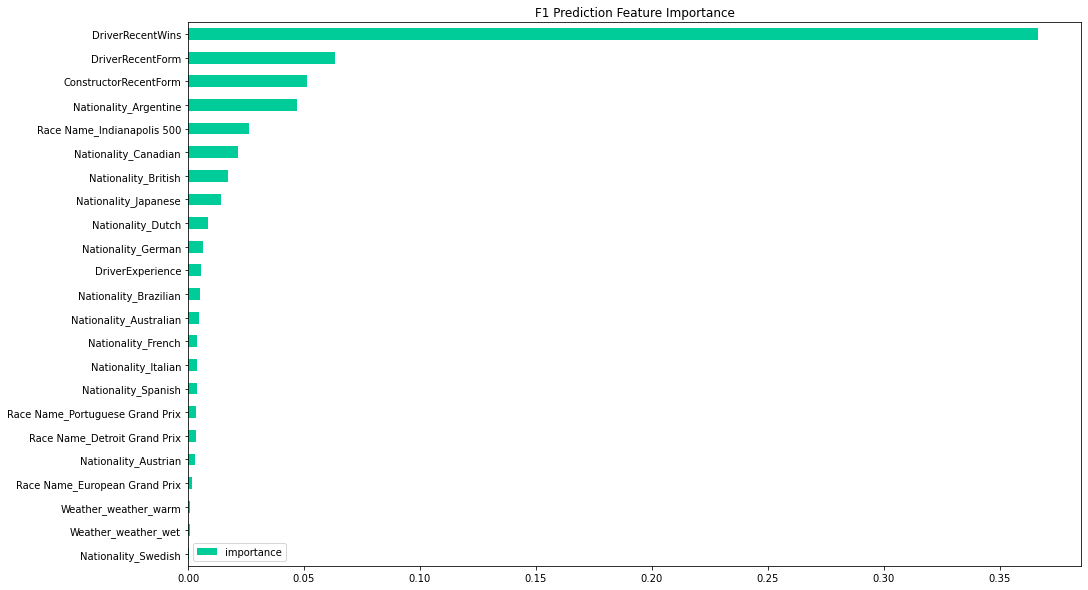

In [355]:
def feature_importance_using_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Assess the importance of features using Linear Regression coefficients
    importance = model.coef_
    importance_df = pd.DataFrame(importance, columns = ['importance'])
    features_df = pd.DataFrame(results_df.columns.tolist(), columns = ['feature_name'])
    features_df.drop(features_df[(features_df['feature_name'] == 'Driver') | (features_df['feature_name'] == 'Position')].index, inplace=True)
    merged_features_df = pd.concat([importance_df, features_df.reset_index(drop=True)], axis=1)
    merged_features_df.sort_values(by='importance', ascending=True, inplace=True)
    merged_features_df.set_index('feature_name', inplace=True)
    selected_features_df = merged_features_df[(merged_features_df['importance'] > 0)][['importance']]

    # plot feature importance 
    axis = selected_features_df.plot(kind='barh', title="F1 Prediction Feature Importance", figsize=(16, 10), color='#00CC99')
    y_label = axis.yaxis.get_label()
    y_label.set_visible(False)

feature_importance_using_linear_regression(X_train, y_train)

#### Feature importance using Random Forest

imp_mask  importance
feature_name                                            
Grid                                    True    0.150197
DriverRecentForm                        True    0.119112
ConstructorRecentForm                   True    0.113140
DriverRecentWins                        True    0.073343
Season                                  True    0.066364
Round                                   True    0.063992
Age                                     True    0.060626
DriverRecentDNFs                        True    0.047086
DriverExperience                        True    0.045102
Weather_weather_warm                    True    0.016472
ConstructorExperience                  False    0.013140
Weather_weather_dry                    False    0.010116
Nationality_British                    False    0.010064
Weather_weather_hot                    False    0.008448
Race Name_Italian Grand Prix           False    0.008315
Weather_weather_wet                    False    0.008052
Race Name_Belgian Grand Prix           False    0.007769
IsHomeCountry                          False    0.007731
Race Name_British Grand Prix           False    0.007701
Race Name_Monaco Grand Prix            False    0.007615
Race Name_German Grand Prix            False    0.007439
Race Name_French Grand Prix            False    0.007222
Nationality_German                     False    0.006735
Race Name_United States Grand Prix     False    0.006140
Nationality_Brazilian                  False    0.006081
Race Name_Spanish Grand Prix           False    0.005951
Race Name_Canadian Grand Prix          False    0.005885
Race Name_Brazilian Grand Prix         False    0.005844
Race Name_Austrian Grand Prix          False    0.005482
Race Name_Hungarian Grand Prix         False    0.005455
Nationality_French                     False    0.005127
Race Name_Australian Grand Prix        False    0.004712
Nationality_Finnish                    False    0.004693
Nationality_Australian                 False    0.004413
Race Name_Japanese Grand Prix          False    0.004334
Race Name_Dutch Grand Prix             False    0.003995
Race Name_European Grand Prix          False    0.003828
Weather_weather_cold                   False    0.003777
Nationality_Italian                    False    0.003739
Race Name_San Marino Grand Prix        False    0.003566
Race Name_South African Grand Prix     False    0.003518
Nationality_Austrian                   False    0.003452
Race Name_Argentine Grand Prix         False    0.003199
Nationality_Argentine                  False    0.003165
Race Name_Mexican Grand Prix           False    0.003160
Race Name_Malaysian Grand Prix         False    0.003118
Race Name_Portuguese Grand Prix        False    0.003011
Nationality_Spanish                    False    0.002691
Race Name_Chinese Grand Prix           False    0.002614
Nationality_Canadian                   False    0.002482

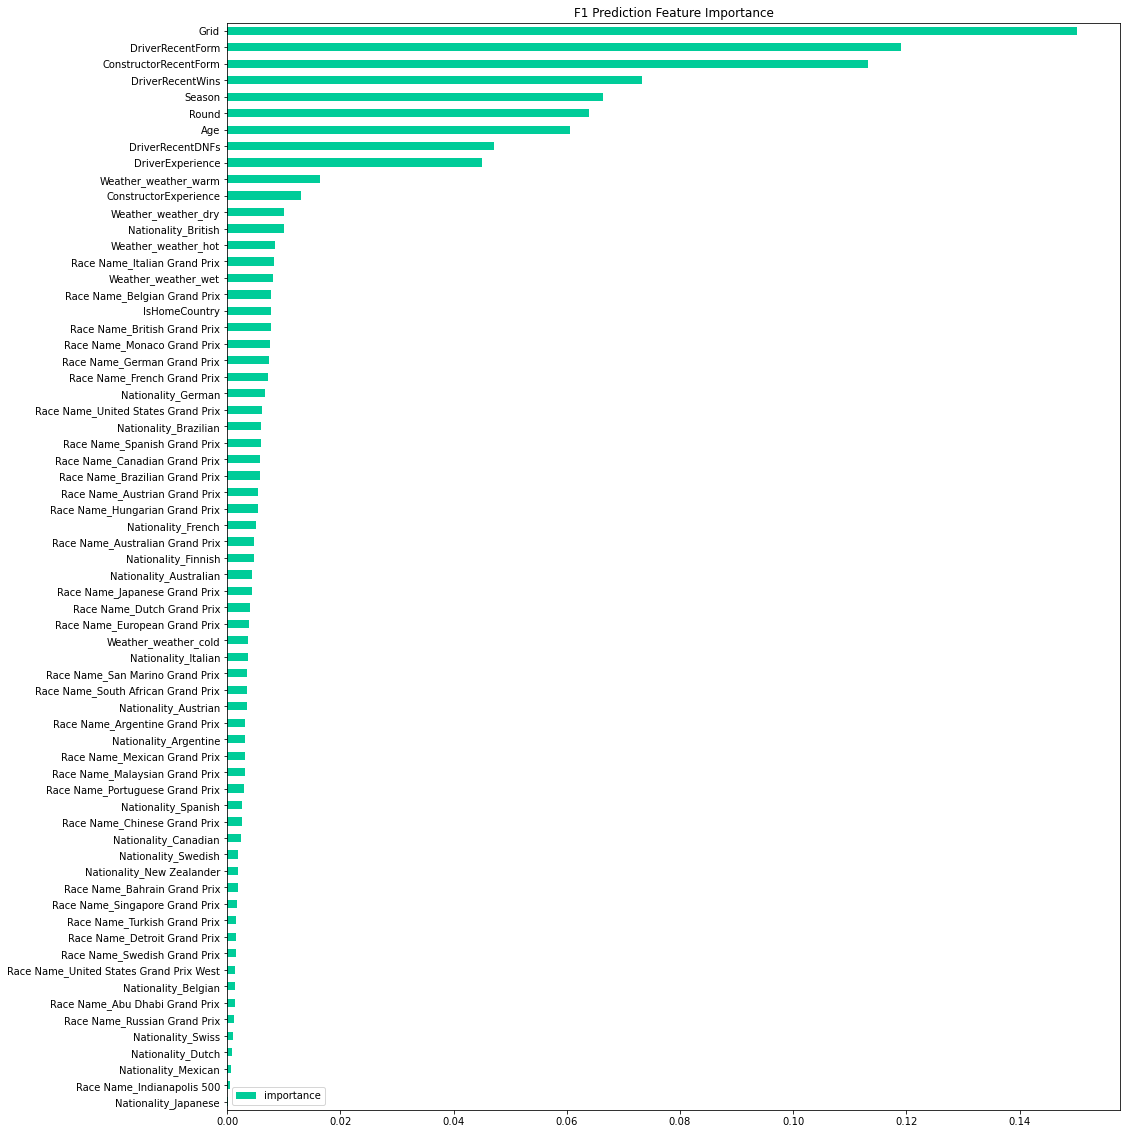

In [533]:
def feature_importance_using_random_forest(X_train, y_train):
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
    sel.fit(X_train, y_train)
    features_to_keep = sel.get_support()
    feature_importance_df = pd.DataFrame(
        {'feature_name': X_train.columns.tolist(),
         'imp_mask': sel.get_support(),
         'importance': sel.estimator_.feature_importances_
        })
    return feature_importance_df, features_to_keep
    
feature_importance_df, features_to_keep = feature_importance_using_random_forest(X_train, y_train)
# feature_importance_df = feature_importance_df[feature_importance_df['imp_mask']==True]
feature_importance_df.sort_values(by='importance', inplace=True)
feature_importance_df.reset_index(drop=True, inplace=True)
feature_importance_df.set_index('feature_name', inplace=True)

# plot feature importance 
axis = feature_importance_df.plot(kind='barh', title="F1 Prediction Feature Importance", figsize=(16, 20), color='#00CC99')
y_label = axis.yaxis.get_label()
y_label.set_visible(False)
feature_importance_df = feature_importance_df.nlargest(50, 'importance')
feature_importance_df


<a id='feature_selection'></a>
#### Feature Selection
Based on the feature importance discovered in the previous section, the identified insignificant features can be safely ommitted as it contributes to model bloat. I've decided to use the features identified by **Random Forest**, since I did not trust the ones from **Linear Regression**. 

In [535]:
def keep_significant_features():
    # keep significant features (Position and Driver will be dropped later, we still need them)
    return results_df[feature_importance_df.index.tolist() + ['Position','Driver']]
results_df = keep_significant_features()
results_df.columns

Index(['Grid', 'DriverRecentForm', 'ConstructorRecentForm', 'DriverRecentWins',
       'Season', 'Round', 'Age', 'DriverRecentDNFs', 'DriverExperience',
       'Weather_weather_warm', 'ConstructorExperience', 'Weather_weather_dry',
       'Nationality_British', 'Weather_weather_hot',
       'Race Name_Italian Grand Prix', 'Weather_weather_wet',
       'Race Name_Belgian Grand Prix', 'IsHomeCountry',
       'Race Name_British Grand Prix', 'Race Name_Monaco Grand Prix',
       'Race Name_German Grand Prix', 'Race Name_French Grand Prix',
       'Nationality_German', 'Race Name_United States Grand Prix',
       'Nationality_Brazilian', 'Race Name_Spanish Grand Prix',
       'Race Name_Canadian Grand Prix', 'Race Name_Brazilian Grand Prix',
       'Race Name_Austrian Grand Prix', 'Race Name_Hungarian Grand Prix',
       'Nationality_French', 'Race Name_Australian Grand Prix',
       'Nationality_Finnish', 'Nationality_Australian',
       'Race Name_Japanese Grand Prix', 'Race Name_Dutch Gr

In [26]:
results_df.shape

(25380, 68)

In [537]:
from sklearn.preprocessing import MinMaxScaler
# Prepare train set
np.set_printoptions(precision=4)
model_df = results_df.copy()
model_df['Position'] = model_df['Position'].map(lambda x: 1 if x == 1 else 0)

train = model_df[(model_df['Season'] >= 1950) & (model_df['Season'] < 2021)]
X_train = train.drop(['Position','Driver'], axis = 1)
y_train = train['Position']

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train, y_train), columns = X_train.columns)
X_train.shape


(24800, 50)

<a id='regression_approaches'></a>
### Regression Approaches

The problem of predicting the winner of a race can be considered a regression problem. We do this by submitting the independent variables (20 drivers) to the chosen machine learning algorithm, and allow the algorithm to make a winner prediction. In fact, the estimator does not only pick a winner among the 20 drivers. It responds with a "prediction" column, where it is sorted descending order, and can be used as the predicted finishing order of the race. The driver that ends up at the top of this list is the winner of this race. 

The following Regression techniques are applied to help solve our problem:
- Linear Regression
- Ada Boost Regressor
- Bagging Regressor
- Extra Trees Regressor
- Gradient Boosting Regressor
- Random Forest Regressor
- Stacking Regressor
- Neural Network (MLP Regressor)

<img src="presentation/reveal.js/images/f1-regression-approach.png" width="600" height="400" />


#### Linear Regression

In [189]:
def linear_regression(X_train, y_train):
    params={'fit_intercept': ['True', 'False']}

    for fit_intercept in params['fit_intercept']:
        start = timer()
        model_params = (fit_intercept)
        model = LinearRegression(fit_intercept = fit_intercept)
        model.fit(X_train, y_train)
        end = timer()
        scoring_raw['train_time'].append(end - start)

        start = timer()
        model_score = regression_test_score(model)
        end = timer()

        scoring_raw['model'].append('Linear Regression')
        scoring_raw['score'].append(np.round(model_score*100, 3))
        scoring_raw['params'].append(model_params)
        scoring_raw['test_time'].append(end - start)
        


#### AdaBoost Regressor

In [180]:
def adaboost_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'learning_rate': [0.001,0.01,0.1,1],
            'loss': ['linear','square','exponential']}

    for n_estimators in params['n_estimators']:
        for learning_rate in params['learning_rate']:
            for loss in params['loss']:
                start = timer()
                model_params = (n_estimators, learning_rate, loss)
                model = AdaBoostRegressor(random_state=0, n_estimators=n_estimators, learning_rate=learning_rate, loss=loss)
                model.fit(X_train, y_train)
                end = timer()
                scoring_raw['train_time'].append(end - start)

                start = timer()
                model_score = regression_test_score(model)
                end = timer()

                scoring_raw['model'].append('AdaBoost Regressor')
                scoring_raw['score'].append(np.round(model_score*100, 3))
                scoring_raw['params'].append(model_params)
                scoring_raw['test_time'].append(end - start)
        


#### Bagging Regressor

In [526]:
def bagging_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_samples': [10,20,30],
            'max_features': [20,40,50],
            'bootstrap': [True,False],
            'bootstrap_features': [True,False]}

    for n_estimators in params['n_estimators']:
        for max_samples in params['max_samples']:
            for max_features in params['max_features']:
                for bootstrap in params['bootstrap']:
                    for bootstrap_features in params['bootstrap_features']:
                        start = timer()
                        model_params = (n_estimators, max_samples, max_features, bootstrap, bootstrap_features)
                        model = BaggingRegressor(random_state=0, base_estimator=DecisionTreeRegressor(),
                             n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, bootstrap=bootstrap, bootstrap_features=bootstrap_features)
                        model.fit(X_train, y_train)
                        end = timer()
                        scoring_raw['train_time'].append(end - start)

                        start = timer()
                        model_score = regression_test_score(model)
                        end = timer()

                        scoring_raw['model'].append('Bagging Regressor (DT)')
                        scoring_raw['score'].append(np.round(model_score*100, 3))
                        scoring_raw['params'].append(model_params)
                        scoring_raw['test_time'].append(end - start)
        
bagging_regressor(X_train, y_train)

In [496]:
running_score = pd.DataFrame(scoring_raw)
running_score.score.value_counts()
running_score.head(50)

model                       params   score  train_time  \
0   Bagging Regressor (DT)    (100, 10, 20, True, True)  38.095    0.233318   
1   Bagging Regressor (DT)   (100, 10, 20, True, False)  38.095    0.213632   
2   Bagging Regressor (DT)   (100, 10, 20, False, True)  33.333    0.212461   
3   Bagging Regressor (DT)  (100, 10, 20, False, False)  38.095    0.211680   
4   Bagging Regressor (DT)    (100, 10, 50, True, True)  47.619    0.480269   
5   Bagging Regressor (DT)   (100, 10, 50, True, False)  33.333    0.468580   
6   Bagging Regressor (DT)   (100, 10, 50, False, True)  42.857    0.467698   
7   Bagging Regressor (DT)  (100, 10, 50, False, False)  38.095    0.462829   
8   Bagging Regressor (DT)    (100, 10, 60, True, True)  42.857    0.577932   
9   Bagging Regressor (DT)   (100, 10, 60, True, False)  42.857    0.586996   
10  Bagging Regressor (DT)   (100, 10, 60, False, True)  33.333    0.591305   
11  Bagging Regressor (DT)  (100, 10, 60, False, False)  38.095    0.597226   
12  Bagging Regressor (DT)    (100, 20, 20, True, True)  42.857    0.211228   
13  Bagging Regressor (DT)   (100, 20, 20, True, False)  42.857    0.211595   
14  Bagging Regressor (DT)   (100, 20, 20, False, True)  42.857    0.226894   
15  Bagging Regressor (DT)  (100, 20, 20, False, False)  42.857    0.213197   
16  Bagging Regressor (DT)    (100, 20, 50, True, True)  42.857    0.458122   
17  Bagging Regressor (DT)   (100, 20, 50, True, False)  47.619    0.469801   
18  Bagging Regressor (DT)   (100, 20, 50, False, True)  38.095    0.475078   
19  Bagging Regressor (DT)  (100, 20, 50, False, False)  47.619    0.463000   
20  Bagging Regressor (DT)    (100, 20, 60, True, True)  33.333    0.607960   
21  Bagging Regressor (DT)   (100, 20, 60, True, False)  38.095    0.586441   
22  Bagging Regressor (DT)   (100, 20, 60, False, True)  33.333    0.584668   
23  Bagging Regressor (DT)  (100, 20, 60, False, False)  38.095    0.588140   
24  Bagging Regressor (DT)    (100, 30, 20, True, True)  33.333    0.214778   
25  Bagging Regressor (DT)   (100, 30, 20, True, False)  52.381    0.211576   
26  Bagging Regressor (DT)   (100, 30, 20, False, True)  33.333    0.218099   
27  Bagging Regressor (DT)  (100, 30, 20, False, False)  52.381    0.218288   
28  Bagging Regressor (DT)    (100, 30, 50, True, True)  42.857    0.458911   
29  Bagging Regressor (DT)   (100, 30, 50, True, False)  42.857    0.474571   
30  Bagging Regressor (DT)   (100, 30, 50, False, True)  42.857    0.472724   
31  Bagging Regressor (DT)  (100, 30, 50, False, False)  42.857    0.485122   
32  Bagging Regressor (DT)    (100, 30, 60, True, True)  38.095    0.595225   
33  Bagging Regressor (DT)   (100, 30, 60, True, False)  33.333    0.605169   
34  Bagging Regressor (DT)   (100, 30, 60, False, True)  38.095    0.598013   
35  Bagging Regressor (DT)  (100, 30, 60, False, False)  33.333    0.610230   
36  Bagging Regressor (DT)    (200, 10, 20, True, True)  33.333    0.413500   
37  Bagging Regressor (DT)   (200, 10, 20, True, False)  33.333    0.426104   
38  Bagging Regressor (DT)   (200, 10, 20, False, True)  33.333    0.421968   
39  Bagging Regressor (DT)  (200, 10, 20, False, False)  33.333    0.414768   
40  Bagging Regressor (DT)    (200, 10, 50, True, True)  66.667    0.924459   
41  Bagging Regressor (DT)   (200, 10, 50, True, False)  38.095    0.934540   
42  Bagging Regressor (DT)   (200, 10, 50, False, True)  61.905    0.918467   
43  Bagging Regressor (DT)  (200, 10, 50, False, False)  38.095    0.915788   
44  Bagging Regressor (DT)    (200, 10, 60, True, True)  33.333    1.191411   
45  Bagging Regressor (DT)   (200, 10, 60, True, False)  38.095    1.179926   
46  Bagging Regressor (DT)   (200, 10, 60, False, True)  33.333    1.174052   
47  Bagging Regressor (DT)  (200, 10, 60, False, False)  38.095    1.199397   
48  Bagging Regressor (DT)    (200, 20, 20, True, True)  38.095    0.416047   
49  Bagging Regressor (DT)   (200, 20, 20, True, False)  38.095    0.42

#### ExtraTrees Regressor

In [182]:
def extratrees_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_depth': [10],
            'min_samples_split': [2,4,6],
            'min_samples_leaf': [1,3,5],
            'max_features': ['auto','sqrt','log2']}

    for n_estimators in params['n_estimators']:
            for max_depth in params['max_depth']:
                for min_samples_split in params['min_samples_split']:
                    for min_samples_leaf in params['min_samples_leaf']:
                        for max_features in params['max_features']:
                            start = timer()
                            model_params = (n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
                            model = ExtraTreesRegressor(random_state=0, n_estimators=n_estimators,
                                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                                        min_samples_leaf=min_samples_leaf, max_features=max_features)
                            model.fit(X_train, y_train)
                            end = timer()
                            scoring_raw['train_time'].append(end - start)

                            start = timer()
                            model_score = regression_test_score(model)
                            end = timer()

                            scoring_raw['model'].append('Extra Trees Regressor')
                            scoring_raw['score'].append(np.round(model_score*100, 3))
                            scoring_raw['params'].append(model_params)
                            scoring_raw['test_time'].append(end - start)
        


#### Gradient Boosting Regressor

In [183]:
def gradientboosting_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'learning_rate': [0.001,0.01,0.1,1],
            'subsample': [0.001,0.1,1],
            'max_depth': [5,10,20]}

    for n_estimators in params['n_estimators']:
            for learning_rate in params['learning_rate']:
                for subsample in params['subsample']:
                        for max_depth in params['max_depth']:
                            start = timer()
                            model_params = (n_estimators, learning_rate, subsample, max_depth)
                            model = GradientBoostingRegressor(random_state=0, n_estimators=n_estimators,
                                                        learning_rate=learning_rate, subsample=subsample,
                                                         max_depth=max_depth)
                            model.fit(X_train, y_train)
                            end = timer()
                            scoring_raw['train_time'].append(end - start)

                            start = timer()
                            model_score = regression_test_score(model)
                            end = timer()

                            scoring_raw['model'].append('Gradient Boosting Regressor')
                            scoring_raw['score'].append(np.round(model_score*100, 3))
                            scoring_raw['params'].append(model_params)
                            scoring_raw['test_time'].append(end - start)
        


#### Random Forest Regressor

In [184]:
def random_forest_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_depth': [10],
            'min_samples_split': [2,4,6],
            'min_samples_leaf': [1,3,5],
            'max_features': ['auto','sqrt','log2']}

    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:
                for min_samples_leaf in params['min_samples_leaf']:
                    for max_features in params['max_features']:
                        start = timer()
                        model_params = (n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
                        model = RandomForestRegressor(random_state=0, n_estimators=n_estimators, max_depth=max_depth,
                                                     min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                                     max_features=max_features)
                        model.fit(X_train, y_train)
                        end = timer()
                        scoring_raw['train_time'].append(end - start)

                        start = timer()
                        model_score = regression_test_score(model)
                        end = timer()

                        scoring_raw['model'].append('Random Forest Regressor')
                        scoring_raw['score'].append(np.round(model_score*100, 3))
                        scoring_raw['params'].append(model_params)
                        scoring_raw['test_time'].append(end - start)
        


#### Stacking Regressor

In [185]:
def stacking_regressor(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_depth': [10]}

    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            start = timer()
            model_params = (n_estimators, max_depth)
            estimators = [('lr', RidgeCV()),('adr', ARDRegression())]
            model = StackingRegressor(estimators=estimators,
                                      final_estimator=RandomForestRegressor(random_state=0, n_estimators=n_estimators, max_depth=max_depth))
            model.fit(X_train, y_train)
            end = timer()
            scoring_raw['train_time'].append(end - start)

            start = timer()
            model_score = regression_test_score(model)
            end = timer()

            scoring_raw['model'].append('Stacking Regressor (RF)')
            scoring_raw['score'].append(np.round(model_score*100, 3))
            scoring_raw['params'].append(model_params)
            scoring_raw['test_time'].append(end - start)
        


#### Neural Network - MLP Regressor

In [186]:
def mlp_regressor(X_train, y_train):
    params={
        'hidden_layer_sizes': [(80,20,40,5), (75,30,50,10,3)], 
        'activation': ['identity', 'relu','logistic',], 
        'solver': ['lbfgs','sgd', 'adam'], 
        'alpha': np.logspace(-4,1,10)}

    for hidden_layer_sizes in params['hidden_layer_sizes']:
        for activation in params['activation']:
            for solver in params['solver']:
                for alpha in params['alpha']:
                    start = timer()
                    model_params = (hidden_layer_sizes, activation, solver, alpha)
                    model = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=hidden_layer_sizes,
                                        activation=activation, solver=solver, alpha=alpha)
                    model.fit(X_train, y_train)
                    end = timer()
                    scoring_raw['train_time'].append(end - start)

                    start = timer()
                    model_score = regression_test_score(model)
                    end = timer()

                    scoring_raw['model'].append('Neural Network - MLP Regressor')
                    scoring_raw['score'].append(np.round(model_score*100, 3))
                    scoring_raw['params'].append(model_params)
                    scoring_raw['test_time'].append(end - start)
        


In [187]:
scoring_raw ={'model':[], 'params': [], 'score': [], 'train_time': [], 'test_time': []}

In [190]:
# run all Regressors + the Dumb Classifier
regressors = [('Dumb Classifier', joses_dumb_classifier),
              ('Linear Regression', linear_regression),
              ('AdaBoost Regressor', adaboost_regressor),
              ('Bagging Regressor', bagging_regressor),
              ('Gradient Boosting Regressor', gradientboosting_regressor),
              ('Random Forest Regressor', random_forest_regressor),
              ('Stacking Regressor (RF)', stacking_regressor),
              ('Neural Network (MLP Regressor)', mlp_regressor)]

start = timer()
for regressor in regressors:
    start_reg = timer()
    print(f'Running {regressor[0]}')
    regressor[1](X_train, y_train)
    end_reg = timer()
    print(f'{regressor[0]} done => {np.round(end_reg - start_reg, 4)}s.')
end = timer()

print(f'Running all regressors: {np.round(end - start, 4)}s')
running_score = pd.DataFrame(scoring_raw)
running_score

running_score.to_csv('regressions_scores.csv')

Running Dumb Classifier
Dumb Classifier done => 0.1877s.
Running Linear Regression
Linear Regression done => 0.4183s.
Running AdaBoost Regressor
AdaBoost Regressor done => 332.6744s.
Running Bagging Regressor
Bagging Regressor done => 134.8787s.
Running Gradient Boosting Regressor
Gradient Boosting Regressor done => 1111.0537s.
Running Random Forest Regressor
Random Forest Regressor done => 585.9226s.
Running Stacking Regressor (RF)
Stacking Regressor (RF) done => 16.3893s.
Running Neural Network (MLP Regressor)
Neural Network (MLP Regressor) done => 1744.2518s.
Running all regressors: 3925.7784s


model  \
0            Jose's Dumb Classifier   
1                 Linear Regression   
2                 Linear Regression   
3                AdaBoost Regressor   
4                AdaBoost Regressor   
..                              ...   
514  Neural Network - MLP Regressor   
515  Neural Network - MLP Regressor   
516  Neural Network - MLP Regressor   
517  Neural Network - MLP Regressor   
518  Neural Network - MLP Regressor   

                                                params   score  train_time  \
0                                                 none   9.524    0.000002   
1                                                 True  38.095    0.037792   
2                                                False  38.095    0.020009   
3                                 (100, 0.001, linear)  47.619    7.460298   
4                                 (100, 0.001, square)  47.619    7.335898   
..                                                 ...     ...         ...   
514  ((75, 30, 50, 10, 3), logistic, adam, 0.059948...   0.000    2.893149   
515  ((75, 30, 50, 10, 3), logistic, adam, 0.215443...   4.762    3.605735   
516  ((75, 30, 50, 10, 3), logistic, adam, 0.774263...   4.762    4.389698   
517  ((75, 30, 50, 10, 3), logistic, adam, 2.782559...   0.000    5.892418   
518        ((75, 30, 50, 10, 3), logistic, adam, 10.0)   0.000    5.196142   

     test_time  
0     0.187482  
1     0.181738  
2     0.178630  
3     0.315744  
4     0.278544  
..         ...  
514   0.199185  
515   0.191327  
516   0.197765  
517   0.195098  
518   0.194635  

[519 rows x 5 columns]

<a id='classification_approaches'></a>
### Classification Approaches

This problem can also be approached as a classification problem since we want to predict 2 categories - the race winner, and then everybody else. Like the Regression problem, we will need to submit the details for the 20 competitors, wherein the classification algorithm will predict if the driver WILL WIN, or NOT WIN. Because this produces 2 columns of probabilities for all competitors, we can then simply sort this, and the one with the highest probability of winning will be our winner. 

The following classification models were used:

- Logistic Regression
- Random Forest Classifier
- SVM Classifier
- Ada Boost Classifier
- Extra Trees  Classifier
- Gradient Boosting
- Stacking Classifier
- Neural Networks (MLP Classifier)

<img src="./presentation/reveal.js/images/f1-classification-approach.png" width="600" height="400" />

#### Classification Function

In [262]:
from sklearn.preprocessing import MinMaxScaler

def classification_test_score(model):
    # --- Test ---
    score = 0
    races = model_df[(model_df['Season'] == 2021)]['Round'].unique()
    for race in races:
        test = model_df[(model_df['Season'] == 2021) & (model_df['Round'] == race)]
        X_test = test.drop(['Position','Driver'], axis = 1)
        y_test = test['Position']
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_not_win', 'proba_win'])
        merged_df = pd.concat([prediction_df, test[['Driver','Position']].reset_index(drop=True)], axis=1)
        merged_df.rename(columns = {'Position': 'actual_pos'}, inplace = True)
        
        # shuffle data to remove original order that will influence selection
        # of race winner when there are drivers with identical win probablilities
        merged_df = merged_df.sample(frac=1).reset_index(drop=True)
        merged_df.sort_values(by='proba_win', ascending=False, inplace=True)
        merged_df['predicted_pos'] = 0
        merged_df.iloc[0, merged_df.columns.get_loc('predicted_pos')] = 1
        merged_df.reset_index(drop=True, inplace=True)
        
        # --- Score ---
        score += precision_score(merged_df['actual_pos'], merged_df['predicted_pos'], zero_division=0)

    return score / len(races)


In [261]:
scoring_clf_raw ={'model':[], 'params': [], 'score': [], 'train_time': [], 'test_time': []}

#### Logistic Regression

I have tried out using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) however, the precision score was a bit lower than the manual search, so I reverted to the manual method. 

In [252]:
def logistic_regression(X_train, y_train):
    params={'penalty': ['l1', 'l2'],
            'solver': ['saga', 'liblinear'],
            'C': np.logspace(-3,1,20)}

    for penalty in params['penalty']:
        for solver in params['solver']:
            for C in params['C']:
                start = timer()
                model_params = (penalty, solver, C)
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter = 10000)
                model.fit(X_train, y_train)
                end = timer()
                scoring_clf_raw['train_time'].append(end - start)

                start = timer()
                model_score = classification_test_score(model)
                end = timer()

                scoring_clf_raw['model'].append('Logistic Regression')
                scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                scoring_clf_raw['params'].append(model_params)
                scoring_clf_raw['test_time'].append(end - start)

def logistic_regression_grid(X_train, y_train):
    params={'penalty': ['l1', 'l2'],
            'solver': ['saga', 'liblinear'],
            'C': np.logspace(-3,1,20)}
    
    start = timer()
    model = GridSearchCV(LogisticRegression(max_iter = 10000), params, cv=2)
    model.fit(X_train, y_train)
    end = timer()
    scoring_clf_raw['train_time'].append(end - start)
        
    start = timer()
    model_score = classification_test_score(model)
    end = timer()
    scoring_clf_raw['model'].append('Logistic Regression')
    scoring_clf_raw['score'].append(np.round(model_score*100, 3))
    scoring_clf_raw['params'].append(model.best_params_)
    scoring_clf_raw['test_time'].append(end - start)
        

#### Random Forest Classifier

Like in Logistic Regression, I have tried out using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) however, the precision score was a bit lower than the manual search, so I reverted to the manual method. 

In [253]:
def random_forest_classifier(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_depth': [10],
            'min_samples_split': [2,4,6],
            'min_samples_leaf': [1,3,5],
            'max_features': ['auto','sqrt','log2']}

    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:
                for min_samples_leaf in params['min_samples_leaf']:
                    for max_features in params['max_features']:
                        start = timer()
                        model_params = (n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
                        model = RandomForestClassifier(random_state=0, n_estimators=n_estimators, max_depth=max_depth,
                                                     min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                                     max_features=max_features)
                        model.fit(X_train, y_train)
                        end = timer()
                        scoring_clf_raw['train_time'].append(end - start)

                        start = timer()
                        model_score = classification_test_score(model)
                        end = timer()

                        scoring_clf_raw['model'].append('Random Forest Classifier')
                        scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                        scoring_clf_raw['params'].append(model_params)
                        scoring_clf_raw['test_time'].append(end - start)
        

def random_forest_classifier_grid(X_train, y_train):
    params={'n_estimators': [100,200,300],
            'max_depth': [10],
            'min_samples_split': [2,4,6],
            'min_samples_leaf': [1,3,5],
            'max_features': ['auto','sqrt','log2']}
    
    start = timer()
    model = GridSearchCV(RandomForestClassifier(random_state=0), params)
    model.fit(X_train, y_train)
    end = timer()
    scoring_clf_raw['train_time'].append(end - start)
        
    start = timer()
    model_score = classification_test_score(model)
    end = timer()
    scoring_clf_raw['model'].append('Random Forest Classifier')
    scoring_clf_raw['score'].append(np.round(model_score*100, 3))
    scoring_clf_raw['params'].append(model.best_params_)
    scoring_clf_raw['test_time'].append(end - start)
        

#### SVM Classifier

In [254]:
def svm_classifier(X_train, y_train):
    params={
        'gamma': np.logspace(-4, -1, 3),
        'C': np.logspace(-2, 1, 3),
        'kernel': ['linear']}
    
    for gamma in params['gamma']:
        for C in params['C']:
            for kernel in params['kernel']:
                start = timer()
                model_params = (gamma, C, kernel)
                model = SVC(probability = True, gamma=gamma, C=C, kernel=kernel)
                model.fit(X_train, y_train)
                end = timer()
                scoring_clf_raw['train_time'].append(end - start)

                start = timer()
                model_score = classification_test_score(model)
                end = timer()

                scoring_clf_raw['model'].append('SVM Classifier')
                scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                scoring_clf_raw['params'].append(model_params)
                scoring_clf_raw['test_time'].append(end - start)
        


#### AdaBoost Classifier

In [255]:
def adaboost_classifier(X_train, y_train):
    params={
        'n_estimators': [100,200,300],
        'learning_rate': [0.001,0.01,0.1,1],
        'algorithm': ['SAMME', 'SAMME.R']}
    
    for n_estimators in params['n_estimators']:
        for learning_rate in params['learning_rate']:
            for algorithm in params['algorithm']:
                start = timer()
                model_params = (n_estimators, learning_rate, algorithm)
                model = AdaBoostClassifier(random_state=0, n_estimators=n_estimators, 
                                          learning_rate=learning_rate, algorithm=algorithm)
                model.fit(X_train, y_train)
                end = timer()
                scoring_clf_raw['train_time'].append(end - start)

                start = timer()
                model_score = classification_test_score(model)
                end = timer()

                scoring_clf_raw['model'].append('Ada Boost Classifier')
                scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                scoring_clf_raw['params'].append(model_params)
                scoring_clf_raw['test_time'].append(end - start)
        

#### ExtraTrees Classifier

In [256]:
def extratrees_classifier(X_train, y_train):
    params={
        'n_estimators': [100,200,300],
        'max_depth': [10],
        'min_samples_split': [2,4,6],
        'min_samples_leaf': [1,3,5],
        'max_features': ['auto','sqrt','log2']}
    
    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:
                for min_samples_leaf in params['min_samples_leaf']:
                    for max_features in params['max_features']:
                        start = timer()
                        model_params = (n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
                        model = ExtraTreesClassifier(random_state=0, n_estimators=n_estimators,
                                                     max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                                     max_features=max_features)
                        model.fit(X_train, y_train)
                        end = timer()
                        scoring_clf_raw['train_time'].append(end - start)

                        start = timer()
                        model_score = classification_test_score(model)
                        end = timer()

                        scoring_clf_raw['model'].append('Extra Trees Classifier')
                        scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                        scoring_clf_raw['params'].append(model_params)
                        scoring_clf_raw['test_time'].append(end - start)
        

#### GradientBoosting Classifier

In [257]:
def gradient_boosting_classifier(X_train, y_train):
    params={
        'n_estimators': [100,200,300],
        'learning_rate': [0.001,0.01,0.1,1],
        'subsample': [0.001,0.1,1],
        'max_depth': [5,10,20]}
    
    for n_estimators in params['n_estimators']:
        for learning_rate in params['learning_rate']:
            for subsample in params['subsample']:
                for max_depth in params['max_depth']:
                    start = timer()
                    model_params = (n_estimators, learning_rate, subsample, max_depth)
                    model = GradientBoostingClassifier(random_state=0, n_estimators=n_estimators,
                                                 learning_rate=learning_rate, subsample=subsample, max_depth=max_depth)
                    model.fit(X_train, y_train)
                    end = timer()
                    scoring_clf_raw['train_time'].append(end - start)

                    start = timer()
                    model_score = classification_test_score(model)
                    end = timer()

                    scoring_clf_raw['model'].append('Gradient Boosting Classifier')
                    scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                    scoring_clf_raw['params'].append(model_params)
                    scoring_clf_raw['test_time'].append(end - start)
        

#### Stacking Classifier

In [258]:
def stacking_classifier(X_train, y_train):
    params={
        'n_estimators': [100,200,300]}
    
    for n_estimators in params['n_estimators']:
        start = timer()
        model_params = (n_estimators)
        estimators = [('rf', RandomForestClassifier(n_estimators=n_estimators, random_state=42)),
                  ('svr', LinearSVC(random_state=45))]

        model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        model.fit(X_train, y_train)
        end = timer()
        scoring_clf_raw['train_time'].append(end - start)

        start = timer()
        model_score = classification_test_score(model)
        end = timer()

        scoring_clf_raw['model'].append('Stacking Classifier')
        scoring_clf_raw['score'].append(np.round(model_score*100, 3))
        scoring_clf_raw['params'].append(model_params)
        scoring_clf_raw['test_time'].append(end - start)
        

#### Neural Network (MLP Classifier)

In [259]:
def mlp_classifier(X_train, y_train):
    params={
        'hidden_layer_sizes': [(80,20,40,5), (75,30,50,10,3)], 
        'activation': ['identity', 'relu','logistic',], 
        'solver': ['lbfgs','sgd', 'adam'], 
        'alpha': np.logspace(-4,1,5)}
    
    for hidden_layer_sizes in params['hidden_layer_sizes']:
        for activation in params['activation']:
            for solver in params['solver']:
                for alpha in params['alpha']:
                    start = timer()
                    model_params = (hidden_layer_sizes, activation, solver, alpha)
                    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, max_iter=20)
                    model.fit(X_train, y_train)
                    end = timer()
                    scoring_clf_raw['train_time'].append(end - start)

                    start = timer()
                    model_score = classification_test_score(model)
                    end = timer()

                    scoring_clf_raw['model'].append('Neural Network (MLP Classifier)')
                    scoring_clf_raw['score'].append(np.round(model_score*100, 3))
                    scoring_clf_raw['params'].append(model_params)
                    scoring_clf_raw['test_time'].append(end - start)
        

In [263]:
# run all Classifiers (more than 8 hours!)
classifiers = [
    ('Logistic Regression', logistic_regression),
    ('Random Forest Classifier', random_forest_classifier),
    ('Neural Network (MLP Classifier)', mlp_classifier),              
    ('AdaBoost Classifier', adaboost_classifier),
    ('Extra Trees Classifier', extratrees_classifier),
    ('Gradient Boosting Classifier', gradient_boosting_classifier),
    ('Stacking Classifier', stacking_classifier),
    # ('SVM Classifier', svm_classifier) => removed as takes a few hours, and with similar results as other models
]

start = timer()
for classifier in classifiers:
    start_clf = timer()
    print(f'Running {classifier[0]}')
    classifier[1](X_train, y_train)
    end_clf = timer()
    print(f'{classifier[0]} done => {np.round(end_clf - start_clf, 4)}s.')
end = timer()

print(f'Running all classifiers: {np.round(end - start, 4)}s')
running_score = pd.DataFrame(scoring_clf_raw)

running_score.to_csv('classification_scores.csv')

Running Logistic Regression
Logistic Regression done => 35.1231s.
Running Random Forest Classifier
Random Forest Classifier done => 250.337s.
Running Neural Network (MLP Classifier)
Neural Network (MLP Classifier) done => 235.9248s.
Running AdaBoost Classifier
AdaBoost Classifier done => 109.1923s.
Running Extra Trees Classifier
Extra Trees Classifier done => 200.5558s.
Running Gradient Boosting Classifier
Gradient Boosting Classifier done => 1413.9461s.
Running Stacking Classifier
Stacking Classifier done => 62.2184s.
Running all classifiers: 2307.3023s


<a id='models_comparison'></a>
#### Comparing all Machine Learning models used

params  \
model                                                                                
Bagging Regressor (DT)                                   (200, 10, 50, True, True)   
Neural Network - MLP Regressor      ((75, 30, 50, 10, 3), 'identity', 'sgd', 10.0)   
Gradient Boosting Regressor                                  (300, 0.1, 0.001, 10)   
Gradient Boosting Classifier                                (200, 0.01, 0.001, 20)   
AdaBoost Regressor                                           (200, 0.01, 'square')   
Random Forest Regressor                                    (300, 10, 2, 5, 'auto')   
Ada Boost Classifier                                           (200, 0.1, 'SAMME')   
Logistic Regression                     ('l1', 'liblinear', 0.0069519279617756054)   
Neural Network (MLP Classifier)  ((80, 20, 40, 5), 'logistic', 'sgd', 0.0017782...   
Linear Regression                                                             True   
Stacking Regressor (RF)                                                  (100, 10)   
Extra Trees Classifier                                     (100, 10, 2, 1, 'auto')   
Random Forest Classifier                                   (100, 10, 2, 3, 'log2')   
Stacking Classifier                                                            100   
Jose's Dumb Classifier                                                        none   

                                  score  train_time  test_time  
model                                                           
Bagging Regressor (DT)           61.905    0.975334   0.416948  
Neural Network - MLP Regressor   61.905   10.226832   0.200022  
Gradient Boosting Regressor      57.143    0.606889   0.171962  
Gradient Boosting Classifier     57.143    0.920284   0.166690  
AdaBoost Regressor               52.381   14.969050   0.449939  
Random Forest Regressor          52.381   23.799965   0.553645  
Ada Boost Classifier             52.381    3.774158   0.445910  
Logistic Regression              47.619    0.049125   0.162838  
Neural Network (MLP Classifier)  42.857    3.335669   0.208089  
Linear Regression                38.095    0.037792   0.181738  
Stacking Regressor (RF)          38.095    2.767714   0.325875  
Extra Trees Classifier           38.095    1.056110   0.330396  
Random Forest Classifier         38.095    1.189105   0.328895  
Stacking Classifier              33.333   10.538083   0.374325  
Jose's Dumb Classifier            9.524    0.000002   0.187482

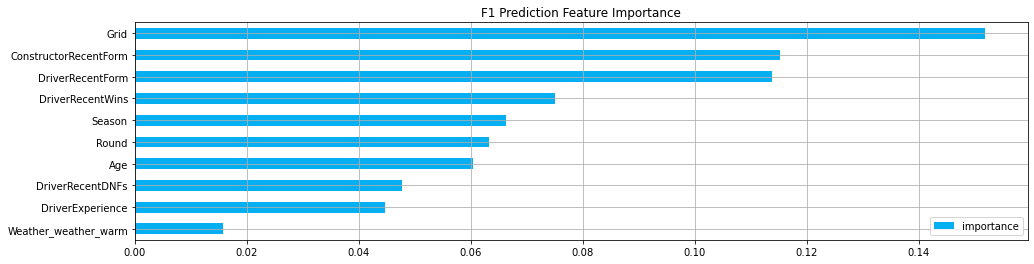

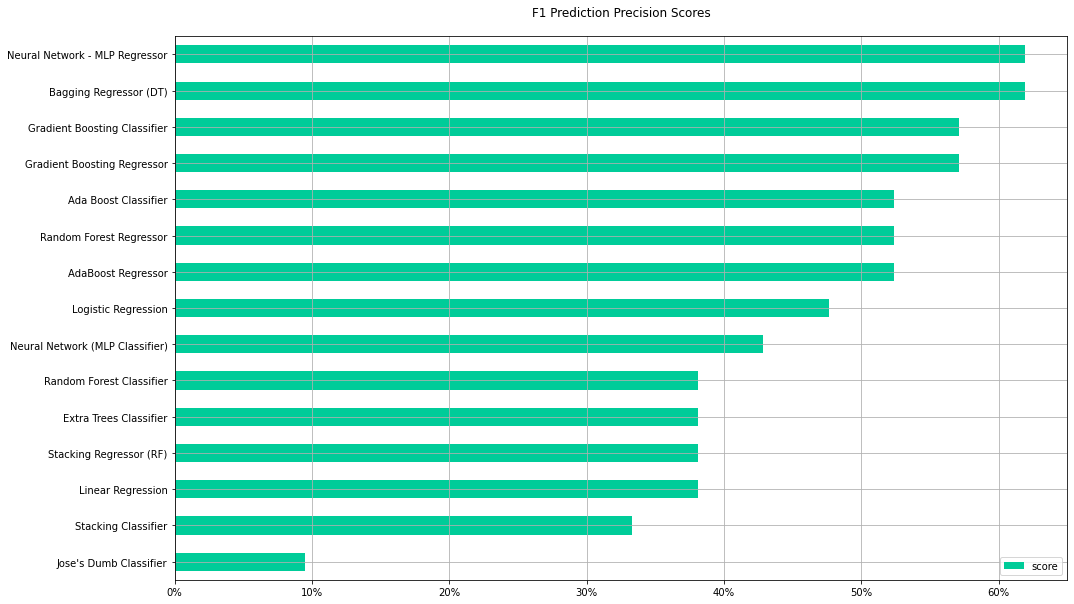

In [278]:
import matplotlib.ticker as mtick

def read_csv_dataframe(filename):
    summary = pd.read_csv(filename)
    summary.drop(columns=['Unnamed: 0'],inplace=True)
    groups = summary.groupby(by=['model'])
    summary = groups.apply(lambda x: x[x['score'] == x['score'].max()].iloc[0])
    summary.sort_values(by='score', inplace=True)
    summary.set_index('model', inplace=True)
    return summary

summary_df = read_csv_dataframe('regressions_scores.csv')
summary_clf_df = read_csv_dataframe('classification_scores.csv')

# merge
merged_scores_df = pd.concat([summary_df, summary_clf_df])
merged_scores_df.sort_values(by='score', inplace=True)
merged_scores_df

# plot feature importance 
axis = feature_importance_df.plot(kind='barh', title="F1 Prediction Feature Importance", figsize=(16, 4), color='#05AFF2', grid=True,)
y_label = axis.yaxis.get_label()
y_label.set_visible(False)

# plot precision scores
axis = merged_scores_df[['score']].plot(kind='barh', figsize=(16,10), color=['#00CC99','#9370DB','#CA98BF'], grid=True, linestyle='--')
axis.xaxis.set_major_formatter(mtick.PercentFormatter())
axis.set_title('F1 Prediction Precision Scores', pad=20)
y_label = axis.yaxis.get_label()
y_label.set_visible(False)
merged_scores_df.sort_values(by='score', inplace=True, ascending=False)
merged_scores_df

### Conclusion

Following our [Champion/Challenger](https://medium.com/@awaiskaleem/mlflow-tips-n-tricks-eb1ac013edd1) model, the winning model is the one built with [Bagging Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) ([Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decisiontree#sklearn.tree.DecisionTreeRegressor)). This is an ensemble model fron SKLearn which uses DecistionTreeRegressor as its base estimator.

[Neural Network - MLP Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor) ended up with the same precision score, however because it took 10x more in training time, I have delegated it to 2nd place. 

- **Bagging Regressor (Decision Tree Regressor)**
- Train time: **0.97s**
- Test time: **0.42s**
- **Grid**, **ConstructorRecentForm**, **DriverRecentForm** and **DriverRecentWins** round out the most significant features. The last 3 are one of the features we engineered for this project.
- Precision score: **61.9%**
- For each race, the finishing order is also available, but omitted here for brevity
- Correctly predicting the winner in **13 out of 21** races in 2021 Season



### Preparing for Rest API

In [85]:
def bagging_regressor_pickle(X_train, y_train):
    # now use the winning paramters to build the model
    model = BaggingRegressor(random_state=0, base_estimator=DecisionTreeRegressor(),
         n_estimators=200, max_samples=10, max_features=50, bootstrap=True, bootstrap_features=True)
    model.fit(X_train, y_train)
    pickle.dump(model, open('f1-model.pkl', 'wb'))
    print(model.n_features_in_)
    

start = timer()
bagging_regressor_pickle(X_train, y_train)
end = timer()
print(f'bagging_regressor_pickle took {end - start} s')

66
bagging_regressor_pickle took 0.9400396940000064 s


In [96]:
start = timer()
from_pickled_model = pickle.load(open('f1-model.pkl', 'rb'))
for i in range(0, 10):
    f1_model_score = regression_test_score(from_pickled_model)
    print(f1_model_score)
end = timer()
print(f'bagging_regressor_inference took {end - start} s')

0.5714285714285714
0.5714285714285714
0.6190476190476191
0.6190476190476191
0.5714285714285714
0.6190476190476191
0.5238095238095238
0.6190476190476191
0.6666666666666666
0.6190476190476191
bagging_regressor_inference took 4.709704332999536 s


In [637]:
results_df.shape

(25380, 68)